In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import SimpleITK as sitk

In [40]:
"""
Function used to normalize the
the input image using Z-score
normalization
"""
def normalizeImage(iImage):
    return (iImage - np.mean(iImage)) / np.std(iImage)

"""
Generate a test image (chess board)
"""
def getChessBoardImage(iImageSize, iArraySieze = 10, dtype = 'uint'):
    """Get the step size"""
    dx = int(np.ceil(iImageSize[0] / iArraySieze)) + 1
    dy = int(np.ceil(iImageSize[1] / iArraySieze)) + 1

    xy = [
        255 * np.ones(shape=(iArraySieze, iArraySieze)),
        np.zeros(shape=(iArraySieze, iArraySieze))
    ]

    """
    vstack stacks arrays vertically (row-wise), meaning it combines arrays along a new first axis.
    hstack stacks arrays horizontally (column-wise), combining arrays along the second axis
    """
    board = np.array(
        np.vstack([
            np.hstack([xy[(i + j) % 2] \
                       for i in range(dx)]) \
            for j in range(dy)
        ]), dtype=dtype
    )

    return board[:iImageSize[0], :iImageSize[1]]

"""
Helper function for defining the deformation
"""
def swirlControlPoints(iCPx, iCPy, a=2.0, b=100.0):
    oCPx = np.array(iCPx)
    oCPy = np.array(iCPy)
    xc = np.mean(oCPx[1:-3,1:-3])
    yc = np.mean(oCPy[1:-3,1:-3])
    rx1 = oCPx[1:-3,1:-3] - xc
    ry1 = oCPy[1:-3,1:-3] - yc
    angle = a*np.exp(-(rx1*rx1+ry1*ry1)/(b*b))
    oCPx[1:-3,1:-3] = np.cos(angle)*rx1 + np.sin(angle)*ry1 + xc
    oCPy[1:-3,1:-3] = -np.sin(angle)*rx1 + np.cos(angle)*ry1 + xc
    return oCPx, oCPy

In [41]:
"""
B-splines
"""
def B0(u):
    return (1 - u)**3 / 6

def B1(u):
    return (3*u**3 - 6*u**2 + 4) / 6

def B2(u):
    return (-3*u**3 + 3*u**2 + 3*u + 1) / 6

def B3(u):
    return u**3 / 6

B = np.array([B0, B1, B2, B3])

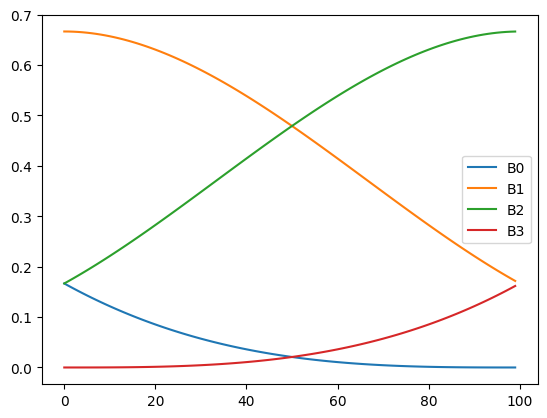

In [42]:
"""
Testing the B-spline functions
"""

data = []
for x in np.arange(0, 1, 0.01):
    data.append([Bt(x) for Bt in B])

data = np.array(data)

plt.figure()
plt.plot(data)
plt.legend(['B0', 'B1', 'B2', 'B3'])
plt.show()

In [43]:
"""
Function that creates a 2D grid of control points
"""
def getCubicBSpline2DGrid(iImageSize, iStep):
    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)

    oCpX, oCpY = np.meshgrid(
        np.arange(-iStep[0], np.ceil(iImageSize[0] / iStep[0] + 3) * iStep[0], iStep[0]),
        np.arange(-iStep[1], np.ceil(iImageSize[1] / iStep[1] + 3) * iStep[1], iStep[1])
    )

    return oCpX, oCpY

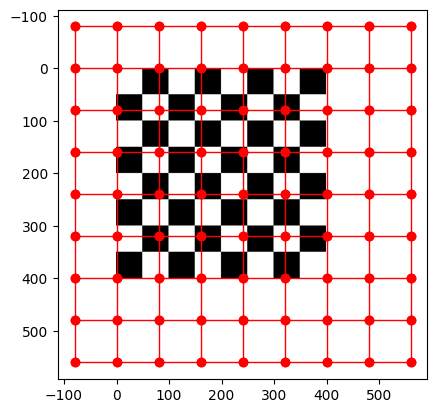

In [44]:
"""
Test the functions
"""
imageSize = (400, 400)
step = (80, 80)

board = getChessBoardImage(imageSize, 50)
cX, cY = getCubicBSpline2DGrid(imageSize, step)

plt.figure()
plt.imshow(board, cmap='gray')
plt.plot(cX, cY, marker='o', color='r', linewidth=1)
plt.plot(cX.transpose(), cY.transpose(), marker='o', color='r', linewidth=1)
plt.show()

In [60]:
"""
Function that calculates the deforamtion field
"""
def getCubicBSpline2DDeformation(iImageSize, iCPx, iCPy, iStep):

    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)

    dx, dy = iImageSize
    gx, gy = np.meshgrid(
        np.arange(dx),
        np.arange(dy)
    )
    gx = np.array(gx, dtype='float64')
    gy = np.array(gy, dtype='float64')
    oGx = np.zeros_like(gx)
    oGy = np.zeros_like(gy)
    # Get the index of the nearest control point
    i = np.floor(gx / iStep[0])
    j = np.floor(gy / iStep[1])
    # Exact location of the pixel within the cell
    u = (gx / iStep[0]) - i
    v = (gy / iStep[1]) - j
    for l in range(4):
        for m in range(4):
            oGx += B[l](u) * B[m](v)*iCPx[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l
            ]
            oGy += B[l](u) * B[m](v)*iCPy[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l
            ]

    return  oGx, oGy

Text(0.5, 1.0, 'Y shift')

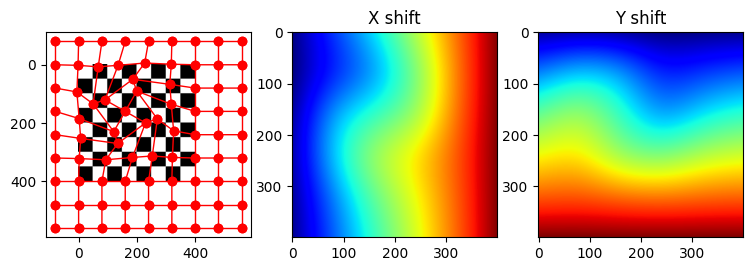

In [46]:
# Shift the control points
oCPx_swirl, oCPy_swirl = swirlControlPoints(cX, cY, a=2.0, b=100.0)

# Calculate the deformation
oGx, oGy = getCubicBSpline2DDeformation(
    board.shape, oCPx_swirl, oCPy_swirl, step)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(board, cmap='gray')
ax1.plot(oCPx_swirl, oCPy_swirl, marker='o', color='r', linewidth=1)
ax1.plot(oCPx_swirl.transpose(), oCPy_swirl.transpose(), marker='o',
         color='r', linewidth=1)
ax2.imshow(oGx, cmap='jet')
ax2.set_title('X shift')
ax3.imshow(oGy, cmap='jet')
ax3.set_title('Y shift')

In [47]:
"""
Deform and interpolate image
"""
def deformImageBSpline2D(iImage, iCPx, iCPy, iStep):
    dx, dy = iImage.shape
    oGx, oGy = getCubicBSpline2DDeformation(iImage.shape, iCPx, iCPy, iStep)
    gx, gy = np.meshgrid(
        np.arange(dx),
        np.arange(dy)
    )
    oGx = 2*gx - oGx
    oGy = 2*gy - oGy

    oImage = interpn(
        (np.arange(dy), np.arange(dx)),
        iImage.astype('float64'),
        np.dstack((oGy, oGx)),
        method='linear',
        bounds_error=False,
        fill_value=0
    )

    return  oImage

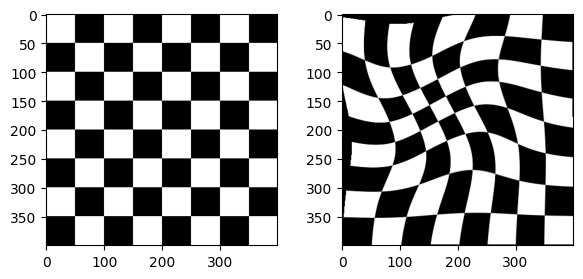

In [48]:
deformedBoard = deformImageBSpline2D(board, oCPx_swirl, oCPy_swirl, step)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.imshow(board, cmap='gray')
ax2.imshow(deformedBoard, cmap='gray')
plt.show()

In [77]:
"""
In this example we will use images of same modality
so Correlaction Coefficient will be used as
similarity matrics. If images of different modality
are used use Mutal Inforamtion
"""
def correlationCoefficient(iImageFixed, iImageMoving):
    fixedFlatten = iImageFixed.flatten()
    movingFlatten = iImageMoving.flatten()

    numerator = np.sum(
        (fixedFlatten - np.mean(fixedFlatten))*(movingFlatten - np.mean(movingFlatten))
    )

    denumerator = np.sqrt(
        np.sum((fixedFlatten - np.mean(fixedFlatten))**2)*np.sum((movingFlatten - np.mean(movingFlatten))**2)
    )

    if denumerator == 0:
        return 0

    return  -numerator / denumerator

In [85]:
"""
Compute gradient
"""
def computeGradient(iFixedImage, iMovingImage, iCPx, iCPy, step, loss, eps = 1e-4):
    startLoss = loss

    gradX = np.zeros_like(iCPx)
    gradY = np.zeros_like(iCPy)

    # Compute the gradient in X direction
    for i in range(np.shape(iCPx)[0]):
        for j in range(np.shape(iCPx)[1]):
            iCPxTemp = iCPx.copy()
            iCPxTemp[i, j] += eps
            deformedImage = deformImageBSpline2D(iMovingImage, iCPxTemp, iCPy, step)
            regularizationTerm = 0.1 * (np.mean(iCPxTemp**2) + np.mean(iCPy**2))
            newLoss = correlationCoefficient(iFixedImage, deformedImage) + regularizationTerm
            gradX[i, j] = (newLoss - startLoss) / eps

    # Compute the gradient in Y direction
    for i in range(np.shape(iCPy)[0]):
        for j in range(np.shape(iCPy)[1]):
            iCPyTemp = iCPy.copy()
            iCPyTemp[i, j] += eps
            deformedImage = deformImageBSpline2D(iMovingImage, iCPx, iCPyTemp, step)
            regularizationTerm = 0.1 * (np.mean(iCPx**2) + np.mean(iCPyTemp**2))
            newLoss = correlationCoefficient(iFixedImage, deformedImage) + regularizationTerm
            gradY[i, j] = (newLoss - startLoss) / eps

    return gradX, gradY

In [95]:
class EarlyStopping:
    def __init__(self, patience=7, initial_lr=8):
        self.losses = []
        self.bestLoss = float('inf')
        self.epochs_since_best = 0
        self.patience = patience
        self.learningRate = initial_lr

    def addLossAndUpdateBest(self, loss):
        self.losses.append(loss)
        if loss < self.bestLoss:
            self.bestLoss = loss
            self.epochs_since_best = 0
        else:
            self.epochs_since_best += 1
            if self.epochs_since_best % 3 == 0:  # Reduce learning rate if no improvement after 3 epochs
                self.learningRate /= 2

    def earlyStop(self):
        return self.epochs_since_best > self.patience


In [98]:
"""
Optimization of control points
"""
def optimizeControlPointsAndGetImage(iFixedImage, iMovingImage, iCPx, iCPy, step, epoch = 10):
    earlyStopping = EarlyStopping()
    for iter in range(epoch):
        deformedImage = deformImageBSpline2D(iMovingImage, iCPx, iCPy, step)
        # Simple regularization (not best for this case)
        regularizationTerm = 0.1 * (np.mean(iCPx**2) + np.mean(iCPy**2))
        loss = correlationCoefficient(iFixedImage, deformedImage) + regularizationTerm
        gradX, gradY = computeGradient(iFixedImage, deformedImage, iCPx, iCPy, step, loss)
        # Gradient descent step
        iCPx -= earlyStopping.learningRate * gradX
        iCPy -= earlyStopping.learningRate * gradY

        earlyStopping.addLossAndUpdateBest(loss)

        if (earlyStopping.earlyStop()):
            break

        print(f"Iteration {iter+1}: Loss = {loss:.6f}")

    return  deformedImage

In [99]:
fixed = sitk.GetArrayFromImage(sitk.ReadImage('../3D2DRegistration/data/mr-nonenhanced.png', sitk.sitkUInt8))
fixed = fixed[:400, :400]
moving = sitk.GetArrayFromImage(sitk.ReadImage('../3D2DRegistration/data/mr-enhanced.png', sitk.sitkUInt8))
step = 80
iCPx, iCPy = getCubicBSpline2DGrid(np.shape(moving), step)
registeredImage = optimizeControlPointsAndGetImage(fixed, moving, iCPx, iCPy, step)

8
Iteration 1: Loss = 20052.658908
0.8
Iteration 2: Loss = 19268.777839
0.08
Iteration 3: Loss = 22891.762165
0.08
Iteration 4: Loss = 9657.332236
0.008
Iteration 5: Loss = 8184.857484
0.0008
Iteration 6: Loss = 8117.969014
8e-05
Iteration 7: Loss = 8118.087265
8e-05
Iteration 8: Loss = 8118.152587
8e-05
Iteration 9: Loss = 8118.227193
8e-05
Iteration 10: Loss = 8118.311021


In [101]:
"""
Fast registration using SimpleITK
"""
fixed = sitk.ReadImage('../3D2DRegistration/data/mr-nonenhanced.png', sitk.sitkFloat32)
moving = sitk.ReadImage('../3D2DRegistration/data/mr-enhanced.png', sitk.sitkFloat32)

R = sitk.ImageRegistrationMethod()

bsplineGrid = 8
bTr = sitk.BSplineTransformInitializer(fixed, [bsplineGrid] * 2)
R.SetInitialTransform(bTr, inPlace=True)

R.SetMetricAsMattesMutualInformation(32)
R.SetMetricSamplingPercentage(0.25)
R.SetMetricSamplingStrategy(R.RANDOM)

R.SetOptimizerAsGradientDescentLineSearch(
    learningRate=5.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-5,
    convergenceWindowSize=5)
R.SetOptimizerScalesFromPhysicalShift()

outTx = R.Execute(fixed, moving)
print(outTx)
S = sitk.ResampleImageFilter()
S.SetReferenceImage(fixed)
S.SetInterpolator(sitk.sitkLinear)
S.SetDefaultPixelValue(0)
S.SetTransform(outTx)
outImage = S.Execute(moving)

itk::simple::BSplineTransform
 BSplineTransform (000001AEE203ADA0)
   RTTI typeinfo:   class itk::BSplineTransform<double,2,3>
   Reference Count: 3
   Modified Time: 119336
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 000001AEE99259A0, 000001AEE9925B80 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [402.25, 407.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [8, 8]
   GridSize: [11, 11]
   GridOrigin: [-50.9062, -51.5312]
   GridSpacing: [50.2812, 50.9062]
   GridDirection: 1 0
0 1




Text(0.5, 1.0, 'After registration')

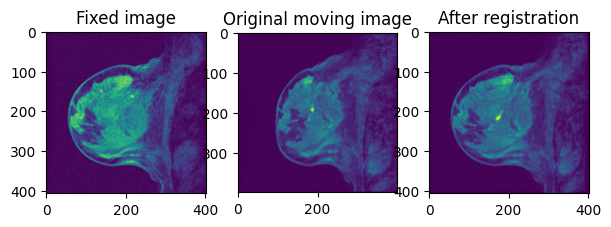

In [106]:
fixed = sitk.GetArrayFromImage(sitk.ReadImage('../3D2DRegistration/data/mr-nonenhanced.png', sitk.sitkUInt8))
moving = sitk.GetArrayFromImage(sitk.ReadImage('../3D2DRegistration/data/mr-enhanced.png', sitk.sitkUInt8))
outImage = sitk.GetArrayFromImage(outImage)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 3))
ax1.imshow(fixed)
ax1.set_title("Fixed image")
ax2.imshow(moving)
ax2.set_title("Original moving image")
ax3.imshow(outImage.reshape((407, 402)))
ax3.set_title("After registration")